In [ ]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
device = torch.cuda.current_device()
print('device:',device)

device: 0


In [ ]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/train_img.csv')
        label = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/test_img.csv')
        label= pd.read_csv('/content/drive/My Drive/Colab_Notebooks/test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)


class RetinopathyLoader(Dataset):
    def __init__(self, root, mode):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)

            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        self.root = root
        self.img_name, self.label = getData(mode)
        self.label=torch.from_numpy(self.label)
        self.mode = mode
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        """something you should implement here"""
        path=self.root+self.img_name[index]+'.jpeg'
        img=Image.open(path)
        label=self.label[index]
        transform = transforms.Compose([
#             transforms.Resize((3,img.size[0],img.size[1])),
            transforms.ToTensor()
        ])
        img=transform(img)
        """
           step1. Get the image path from 'self.img_name' and load it.
                  hint : path = root + self.img_name[index] + '.jpeg'
           
           step2. Get the ground truth label from self.label
                     
           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 
                       
                  In the testing phase, if you have a normalization process during the training phase, you only need 
                  to normalize the data. 
                  
                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]
                         
            step4. Return processed image and label
        """

        return img, label

In [ ]:
torch.cuda.empty_cache()

#Parameter
epochs=6
lr=0.01
batch_size=48
criterion=nn.CrossEntropyLoss()
num_classes=5

train_loader=RetinopathyLoader('/content/drive/My Drive/Colab_Notebooks/data/','train')
img_count=len(train_loader)

train_size = int(1 * img_count)
test_size = img_count - train_size
subset, b = torch.utils.data.random_split(train_loader, [train_size, test_size])

train_loader=DataLoader(subset,batch_size=batch_size,shuffle=True, num_workers=0)
test_loader=RetinopathyLoader('/content/drive/My Drive/Colab_Notebooks/data/','test')
testset_size=len(test_loader)
test_loader=DataLoader(test_loader,batch_size=batch_size,shuffle=True, num_workers=0)

resnet18 = models.resnet18()
resnet18.fc=nn.Linear(512, num_classes)
resnet18=resnet18.cuda()

resnet18_pretraining = models.resnet18(pretrained=True)
resnet18_pretraining.fc=nn.Linear(512, num_classes)
resnet18_pretraining=resnet18_pretraining.cuda()

optimizer=optim.SGD(resnet18.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005)

ignored_params = list(map(id, resnet18_pretraining.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params, resnet18_pretraining.parameters())
# 对不同参数设置不同的学习率
params_list = [{'params': base_params, 'lr': 0.0001},]
params_list.append({'params': resnet18_pretraining.fc.parameters(), 'lr': 0.001})
optimizer_pretraining=optim.SGD(params_list,lr=lr/1000,momentum=0.9,weight_decay=0.005)

> Found 28099 images...
> Found 7025 images...


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
#Train
train_acc=[]
train_acc_pretraining=[]
test_acc=[]
test_acc_pretraining=[]
resnet18.train()
resnet18_pretraining.train()
test_label=[]
test_predict=[]
for epoch in range(epochs):
    correct=0.0
    correct_pretraining=0.0
    running_loss=0.0 
    running_loss_pretrainging=0.0    
    for times,data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=resnet18(inputs)
        _, predict = torch.max(outputs.data, 1)
        correct+=(predict==labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print('[%d/%d] [%d/%d] loss: %.3f' % (epoch+1, epochs, times, len(subset)/batch_size, running_loss))           
        
        optimizer_pretraining.zero_grad()
        outputs=resnet18_pretraining(inputs)
        _, predict = torch.max(outputs.data, 1)
        correct_pretraining+=(predict==labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_pretraining.step()
        running_loss_pretrainging += loss.item()
        print('Pretraing [%d/%d] [%d/%d] loss: %.3f' % (epoch+1, epochs, times, len(subset)/batch_size, running_loss_pretrainging))           
    train_acc.append(correct/len(subset)*100)
    train_acc_pretraining.append(correct_pretraining/len(subset)*100)
  
    epoch_loss = running_loss / len(subset)
    epoch_acc = correct / len(subset) * 100
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    epoch_loss = running_loss_pretrainging / len(subset)
    epoch_acc = correct_pretraining / len(subset) * 100
    print('PreTrain Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    #Test
    correct=0.0
    correct_pretraining=0.0
    with torch.no_grad():
      for data in test_loader:
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=resnet18(inputs)
        _, predict = torch.max(outputs.data, 1)
        correct+=(predict==labels).sum().item()
        
        outputs=resnet18_pretraining(inputs)
        _, predict = torch.max(outputs.data, 1)
        if epoch==epochs-1:
          if len(test_label)==0:
            test_label=labels
            test_predict=predict
          else:
            test_label=torch.cat((test_label,labels),dim=0)
            test_predict=torch.cat((test_predict,predict),dim=0)
        correct_pretraining+=(predict==labels).sum().item()
        print('Pretrain Acc {:.2f}'.format((predict==labels).sum().item()))
      test_acc.append(correct/testset_size*100)
      test_acc_pretraining.append(correct_pretraining/testset_size*100)
      print('Test Acc {:.2f}%' .format(correct/testset_size*100))
      print('Pretrain Acc {:.2f}%' .format(correct_pretraining/testset_size*100))
    

串流輸出內容已截斷至最後 5000 行。
Pretraing [3/6] [146/585] loss: 100.190
[3/6] [147/585] loss: 126.354
Pretraing [3/6] [147/585] loss: 100.864
[3/6] [148/585] loss: 127.446
Pretraing [3/6] [148/585] loss: 101.771
[3/6] [149/585] loss: 128.183
Pretraing [3/6] [149/585] loss: 102.260
[3/6] [150/585] loss: 129.261
Pretraing [3/6] [150/585] loss: 103.082
[3/6] [151/585] loss: 130.253
Pretraing [3/6] [151/585] loss: 103.920
[3/6] [152/585] loss: 131.042
Pretraing [3/6] [152/585] loss: 104.546
[3/6] [153/585] loss: 132.077
Pretraing [3/6] [153/585] loss: 105.271
[3/6] [154/585] loss: 132.862
Pretraing [3/6] [154/585] loss: 105.921
[3/6] [155/585] loss: 133.645
Pretraing [3/6] [155/585] loss: 106.499
[3/6] [156/585] loss: 134.539
Pretraing [3/6] [156/585] loss: 107.178
[3/6] [157/585] loss: 135.485
Pretraing [3/6] [157/585] loss: 107.979
[3/6] [158/585] loss: 136.334
Pretraing [3/6] [158/585] loss: 108.678
[3/6] [159/585] loss: 137.170
Pretraing [3/6] [159/585] loss: 109.315
[3/6] [160/585] loss: 138.089

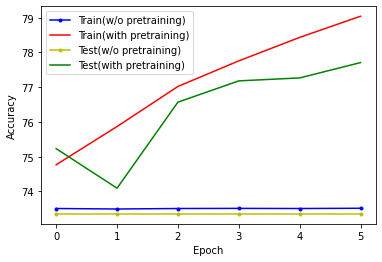

In [ ]:
#畫圖
plt.plot(range(epochs),train_acc,color='b',label='Train(w/o pretraining)',marker='.')
plt.plot(range(epochs),train_acc_pretraining,color='r',label='Train(with pretraining)')
plt.plot(range(epochs),test_acc,color='y',label='Test(w/o pretraining)',marker='.')
plt.plot(range(epochs),test_acc_pretraining,color='g',label='Test(with pretraining)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

torch.Size([5, 1])


Text(0.5, 1.0, 'Normalize confusion matrix')

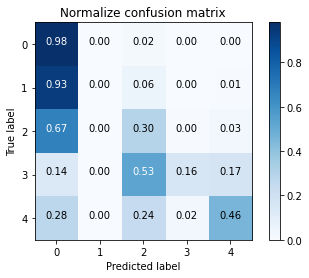

In [ ]:
#confusion matrix
stacked = torch.stack(
    (
        test_label
        ,test_predict
    )
    ,dim=1
)
cm = torch.zeros(num_classes,num_classes)
for item in stacked:
    label, predict = item.tolist()
    cm[label, predict] = cm[label, predict] + 1
print(cm.sum(axis=1)[:,np.newaxis].shape)
cm=cm/cm.sum(axis=1)[:,np.newaxis]
# for i in range(num_classes):
#  cm[i]=cm[i]/cm[i].sum()

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
# tick_marks = np.arange(num_classes)
# plt.xticks(tick_marks, num_classes, rotation=45)
# plt.yticks(tick_marks, num_classes)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    plt.text(j, i, format(cm[i, j],'.2f'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Normalize confusion matrix')